In [175]:
import numpy as np
import mygrad as mg
from mygrad import Tensor

from noggin import create_plot
import matplotlib.pyplot as plt

%matplotlib notebook

In [176]:
from sklearn.model_selection import train_test_split

In [296]:
from cogworks_data.language import get_data_path

from pathlib import Path
import json

# load COCO metadata
filename = get_data_path("captions_train2014.json")
with Path(filename).open() as f:
    coco_data = json.load(f)

In [178]:
badcaptions = coco_data["annotations"]

In [179]:
captions = []
for item in badcaptions:
    if item["image_id"] in resnet18_features:
        captions.append(item)


In [180]:
captions

[{'image_id': 318556,
  'id': 48,
  'caption': 'A very clean and well decorated empty bathroom'},
 {'image_id': 116100,
  'id': 67,
  'caption': 'A panoramic view of a kitchen and all of its appliances.'},
 {'image_id': 318556,
  'id': 126,
  'caption': 'A blue and white bathroom with butterfly themed wall tiles.'},
 {'image_id': 116100,
  'id': 148,
  'caption': 'A panoramic photo of a kitchen and dining room'},
 {'image_id': 379340,
  'id': 173,
  'caption': 'A graffiti-ed stop sign across the street from a red car '},
 {'image_id': 379340,
  'id': 188,
  'caption': 'A vandalized stop sign and a red beetle on the road'},
 {'image_id': 318556,
  'id': 219,
  'caption': 'A bathroom with a border of butterflies and blue paint on the walls above it.'},
 {'image_id': 318556,
  'id': 255,
  'caption': 'An angled view of a beautifully decorated bathroom.'},
 {'image_id': 134754,
  'id': 272,
  'caption': 'The two people are walking down the beach.'},
 {'image_id': 538480,
  'id': 288,
  'ca

In [181]:
# load saved image descriptor vectors
import pickle
with Path(get_data_path('resnet18_features.pkl')).open('rb') as f:
    resnet18_features = pickle.load(f)

In [182]:
from gensim.models import KeyedVectors
filename = "glove.6B.200d.txt.w2v"

# this takes a while to load -- keep this in mind when designing your capstone project
glove = KeyedVectors.load_word2vec_format(get_data_path(filename), binary=False)

In [183]:
image_IDs = [i["image_id"] for i in captions]
caption_IDs = [i["id"] for i in captions]

In [184]:
#Dictionary 1:
#image-ID -> [cap-ID-1, cap-ID-2, ...]


img2captions = {}

for cap in coco_data["annotations"]:
    if cap["image_id"] not in img2captions:
        img2captions[cap["image_id"]] = []
    img2captions[cap["image_id"]].append(cap["id"])

In [185]:
#Dictionary 2:
#caption-ID -> image-ID

cap2img = {}

for caption in coco_data["annotations"]:
    cap2img[caption["id"]] = caption["image_id"]

In [186]:
#Dictionary 3:
#caption-ID -> caption (e.g. 24 -> "two dogs on the grass")

capID2cap = {}

for caption in captions:
    capID2cap[caption["id"]] = caption["caption"]

In [252]:
import re, string
from collections import Counter

punc_regex = re.compile('[{}]'.format(re.escape(string.punctuation)))

def strip_punc(corpus):
    return punc_regex.sub('', corpus)
    
def clean_phrase (text):
    return punc_regex.sub('', text).lower().split(" ")

def get_Counter():
    counter = Counter() 
    for cap in captions :
        cap = cap["caption"]
        clean = set(clean_phrase(cap))
        counter.update(Counter(clean))
    return counter

def get_IDF(counter, word):
    if counter[word] == 0:
        print(word)
    return np.log10( (len(captions) / counter[word] ) )

def get_gloveE(caption):
    if caption in glove:
        return glove[caption]
    return np.zeros((200))

def get_word_vectors(counter, line):
    arr = clean_phrase(line)
    verctor_sum = 0
    for word in arr:
        verctor_sum += (get_IDF(counter, word) * get_gloveE(word))
    return verctor_sum/np.linalg.norm(verctor_sum)

In [253]:
def datasplit(X):
  X_train, X_test = train_test_split(X, train_size=0.8, random_state=50)
  return (X_train, X_test)

In [254]:
np.random.choice([1,2,3], size=10)

array([3, 2, 1, 1, 3, 2, 1, 2, 3, 2])

In [255]:
def generateTriples(imglist, img2captions):
    ret = []
    
    
    fake_list = np.random.choice(imglist, size=10000000)

    counter = 0
    for img in imglist:
        if (counter % 10000 == 0) : print(counter)
        for caption in img2captions[img]:
            #caption = get_word_vectors(Ct, capID2cap[caption])
            counter+=1
            fake= fake_list[counter]
            while (fake == img):
                counter+=1
                fake = fake_list[counter]
            ret.append((caption, img, fake))
    return ret

In [256]:
train, test = datasplit(image_IDs)
train = generateTriples(train, img2captions)
test = generateTriples(test, img2captions)

0
40000
160000
180000
190000
260000
330000
350000
380000
560000
700000
840000
850000
860000
900000
930000
960000
1000000
1020000
1100000
1230000
1240000
1250000
1310000
1320000
1330000
1400000
1430000
1490000
1570000
1600000
1650000
0
80000
90000
140000
150000
190000
260000
270000
280000


In [257]:
from mynn.layers.dense import dense
from mygrad.nnet.initializers import glorot_uniform

In [258]:
class Model:

    def __init__(self, D_input=512, D_glove=200):
        self.dense1 = dense(D_input, D_glove, weight_initializer=glorot_uniform) 

    def __call__(self, x):
        output = self.dense1(x)
        return output/mg.linalg.norm(output, axis = 1, keepdims = True)

    @property
    def parameters(self):
        return self.dense1.parameters

In [259]:
from mynn.optimizers.sgd import SGD
from mygrad.nnet.losses import margin_ranking_loss

model = Model(512, 200)

optim = SGD(model.parameters, learning_rate=1e-3, momentum=0.9)

In [260]:
def accuracy(prediction_truth, prediction_confusion, truth_caption):
    truth_count = np.count_nonzero(np.sum(prediction_truth * truth_caption, axis = 1) > np.sum(prediction_confusion* truth_caption, axis = 1))
    return truth_count / len(truth_caption)

In [261]:
train = np.array(train)
test = np.array(test)

In [270]:
np.save("bias.npy", model.dense1.bias.data)


In [271]:
np.save("weights.npy", model.dense1.weight.data)

<IPython.core.display.Javascript object>


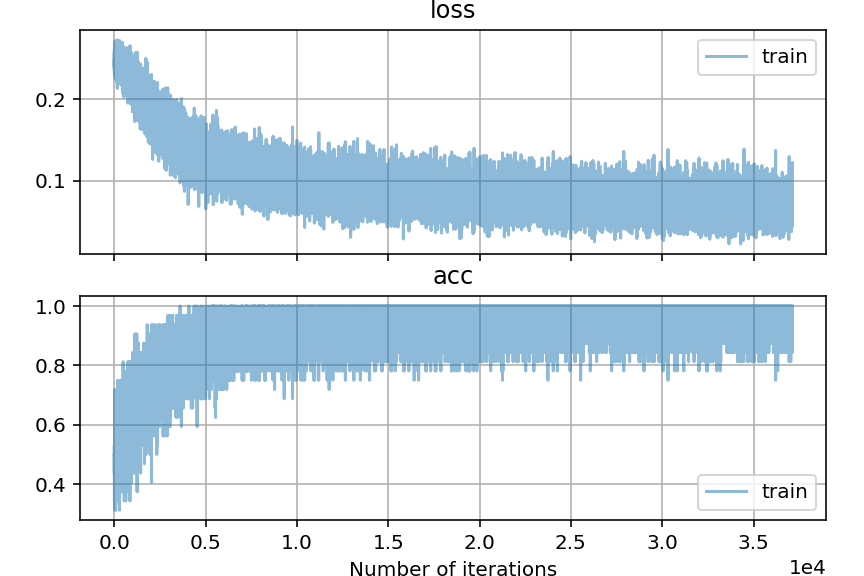

In [262]:
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss", "acc"], max_fraction_spent_plotting=.1)

In [206]:
counter = get_Counter()

In [207]:
counter

Counter({'very': 4587,
         'a': 363121,
         'empty': 2129,
         'and': 91777,
         'well': 602,
         'decorated': 1227,
         'bathroom': 9999,
         'clean': 912,
         'view': 3722,
         'its': 5642,
         'kitchen': 9194,
         'panoramic': 25,
         'of': 127538,
         'all': 1837,
         'appliances': 696,
         'themed': 81,
         'blue': 9387,
         'with': 103207,
         'wall': 4731,
         'butterfly': 45,
         'tiles': 224,
         'white': 24367,
         'dining': 1044,
         'photo': 3790,
         'room': 12713,
         'the': 113851,
         '': 62197,
         'graffitied': 12,
         'street': 20278,
         'sign': 9064,
         'red': 11864,
         'across': 2510,
         'from': 6468,
         'stop': 4335,
         'car': 4864,
         'on': 141073,
         'beetle': 6,
         'road': 6981,
         'vandalized': 62,
         'it': 16598,
         'paint': 225,
         'border': 44

In [263]:
batch_size = 32
num_epochs = 1

for epoch_cnt in range(num_epochs):
    idxs = np.arange(len(train)) 
    np.random.shuffle(idxs)

    for batch_cnt in range(len(train) // batch_size):
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]
        
        # captions
        caption_ids = train[batch_indices][:, 0]
        truth_caption = []
        for cid in caption_ids:
            truth_caption.append(get_word_vectors(counter, capID2cap[cid]))
        truth_caption = np.array(truth_caption)
        
        #generate from ids
        
        #image and confusion
        real_ids = train[batch_indices][:, 1] 
        truth_image = []
        for rid in real_ids:
            truth_image.append(resnet18_features[rid])
        truth_image = np.array(truth_image)[:, 0]
        
        confuse_ids = train[batch_indices][:, 2]
        confusion = []
        for cid in confuse_ids:
            confusion.append(resnet18_features[cid])
        confusion = np.array(confusion)[:, 0]
        
        prediction_truth = model(truth_image)  
        prediction_confusion = model(confusion)
        
        sim_truth = np.sum(prediction_truth * truth_caption, axis = 1)
        #print(sim_truth.shape)
        sim_confusion =  np.sum(prediction_confusion* truth_caption, axis = 1)
        
        # add einsum 
        loss = margin_ranking_loss(sim_truth, sim_confusion, 1, margin=0.25).mean()

        loss.backward() 

        optim.step() 

        acc = accuracy(prediction_truth, prediction_confusion, truth_caption)
        
        plotter.set_train_batch(
            {"loss": loss.item(), "acc": acc}, batch_size=batch_size
        )
       
    
    for batch_cnt in range(0, len(test) // batch_size):
        idxs = np.arange(len(test))
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size] 
        #batch = test[batch_indices]

        with mg.no_autodiff:
            caption_ids = test[batch_indices][:, 0]
            truth_caption = []
            for cid in caption_ids:
                truth_caption.append(get_word_vectors(counter, capID2cap[cid]))
            truth_caption = np.array(truth_caption)

            #generate from ids

            #image and confusion
            real_ids = test[batch_indices][:, 1] 
            truth_image = []
            for rid in real_ids:
                truth_image.append(resnet18_features[rid])
            truth_image = np.array(truth_image)[:, 0]

            confuse_ids = test[batch_indices][:, 2]
            confusion = []
            for cid in confuse_ids:
                confusion.append(resnet18_features[cid])
            confusion = np.array(confusion)[:, 0]

            prediction_truth = model(truth_image)  
            prediction_confusion = model(confusion)

           # sim_truth = np.sum(prediction_truth * truth_caption, axis = 1)
            #print(sim_truth.shape)
            #sim_confusion =  np.sum(prediction_confusion* truth_caption, axis = 1)
            
            
            acc = accuracy(prediction_truth, prediction_confusion, truth_caption)

            plotter.set_test_batch({"acc": acc}, batch_size=batch_size)
    
    plotter.set_train_epoch()
    plotter.set_test_epoch()
plotter.plot()

KeyboardInterrupt: 

In [265]:
array = []
for batch_cnt in range(0, len(test) // batch_size):
        idxs = np.arange(len(test))
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size] 
        #batch = test[batch_indices]

        with mg.no_autodiff:
            caption_ids = test[batch_indices][:, 0]
            truth_caption = []
            for cid in caption_ids:
                truth_caption.append(get_word_vectors(counter, capID2cap[cid]))
            truth_caption = np.array(truth_caption)

            #generate from ids

            #image and confusion
            real_ids = test[batch_indices][:, 1] 
            truth_image = []
            for rid in real_ids:
                truth_image.append(resnet18_features[rid])
            truth_image = np.array(truth_image)[:, 0]

            confuse_ids = test[batch_indices][:, 2]
            confusion = []
            for cid in confuse_ids:
                confusion.append(resnet18_features[cid])
            confusion = np.array(confusion)[:, 0]

            prediction_truth = model(truth_image)  
            prediction_confusion = model(confusion)

           # sim_truth = np.sum(prediction_truth * truth_caption, axis = 1)
            #print(sim_truth.shape)
            #sim_confusion =  np.sum(prediction_confusion* truth_caption, axis = 1)
            
            
            acc = accuracy(prediction_truth, prediction_confusion, truth_caption)

            plotter.set_test_batch({"acc": acc}, batch_size=batch_size)
            array.append(acc)
            print(acc)
#print(array)
print(np.mean(array))

1.0
1.0
0.96875
0.96875
0.9375
0.90625
1.0
1.0
0.96875
1.0
0.96875
0.9375
0.9375
0.9375
1.0
0.9375
0.875
0.9375
0.9375
0.875
0.9375
0.90625
0.9375
1.0
0.9375
0.96875
1.0
0.875
0.9375
0.96875
0.9375
0.9375
0.875
0.875
0.96875
1.0
1.0
0.90625
0.875
0.96875
0.96875
0.9375
0.9375
1.0
0.9375
0.96875
0.96875
0.96875
0.9375
1.0
0.9375
0.96875
0.8125
0.96875
1.0
0.9375
0.96875
1.0
0.84375
0.9375
1.0
0.96875
0.96875
0.96875
0.9375
0.9375
0.9375
1.0
0.90625
0.90625
0.90625
0.96875
0.9375
0.96875
0.96875
0.90625
0.96875
0.875
0.96875
0.90625
0.9375
0.96875
0.96875
0.875
0.9375
1.0
0.9375
0.9375
1.0
0.96875
0.875
0.96875
0.9375
0.90625
1.0
0.875
0.96875
0.9375
0.90625
0.96875
0.875
0.96875
0.96875
0.90625
0.9375
0.96875
0.90625
0.96875
0.90625
0.875
0.9375
0.90625
0.96875
1.0
1.0
0.90625
1.0
1.0
0.90625
0.9375
0.96875
1.0
1.0
0.9375
0.96875
0.9375
0.90625
0.78125
0.9375
0.9375
0.96875
1.0
0.90625
0.90625
0.90625
1.0
0.875
0.96875
0.96875
0.9375
0.9375
0.9375
1.0
0.875
0.9375
1.0
0.96875
1.0
0.9687

0.96875
1.0
0.96875
1.0
1.0
1.0
0.875
0.9375
0.96875
1.0
0.9375
0.96875
1.0
0.9375
0.96875
1.0
0.96875
0.96875
0.96875
1.0
0.96875
1.0
1.0
0.9375
1.0
1.0
0.96875
0.96875
1.0
1.0
1.0
0.96875
0.96875
1.0
0.9375
0.96875
1.0
0.96875
0.9375
0.96875
0.96875
0.9375
0.96875
0.96875
0.90625
0.84375
1.0
1.0
1.0
1.0
0.9375
0.96875
0.90625
0.96875
0.9375
0.9375
0.96875
0.96875
1.0
0.9375
1.0
0.9375
1.0
1.0
0.9375
0.90625
0.96875
0.96875
0.9375
0.96875
0.9375
0.9375
0.875
0.96875
0.96875
1.0
1.0
0.96875
0.96875
0.96875
0.90625
0.96875
0.9375
0.96875
1.0
0.96875
1.0
0.84375
0.96875
0.9375
0.9375
0.96875
0.96875
0.96875
0.96875
0.96875
0.90625
1.0
0.96875
0.90625
0.9375
0.9375
0.96875
0.9375
0.9375
0.96875
0.875
0.96875
0.90625
1.0
1.0
0.90625
0.96875
0.875
0.90625
0.875
0.96875
0.9375
0.9375
1.0
1.0
0.9375
1.0
1.0
0.96875
0.9375
0.84375
0.90625
0.9375
0.9375
1.0
0.96875
1.0
1.0
0.96875
0.9375
0.96875
1.0
1.0
0.90625
1.0
0.96875
0.96875
0.9375
0.9375
1.0
1.0
0.96875
0.9375
1.0
0.96875
0.84375
1.0
0.9

0.96875
0.96875
1.0
1.0
0.96875
0.9375
0.96875
0.90625
0.96875
0.96875
0.875
0.96875
0.875
0.96875
0.9375
1.0
1.0
0.90625
0.96875
0.96875
1.0
0.90625
0.9375
0.96875
0.96875
0.9375
0.96875
0.96875
0.9375
0.90625
0.9375
0.96875
0.90625
0.96875
0.96875
0.9375
0.90625
0.9375
1.0
0.9375
0.90625
0.9375
0.84375
1.0
0.96875
0.96875
0.875
0.90625
0.96875
0.875
0.8125
0.96875
0.9375
1.0
0.9375
0.96875
1.0
0.9375
0.96875
0.96875
1.0
0.90625
0.9375
0.9375
0.90625
0.9375
1.0
0.875
0.9375
0.90625
0.96875
0.96875
0.9375
0.96875
0.96875
0.90625
1.0
0.96875
0.9375
0.96875
0.78125
1.0
0.9375
0.9375
1.0
0.84375
0.9375
0.90625
0.96875
0.96875
0.9375
0.96875
1.0
0.96875
0.96875
1.0
1.0
0.96875
0.96875
0.9375
0.96875
0.96875
0.9375
0.78125
0.9375
1.0
1.0
0.96875
0.96875
0.96875
1.0
1.0
0.9375
0.96875
1.0
0.96875
1.0
0.9375
0.90625
0.84375
0.96875
0.90625
0.96875
0.96875
0.96875
0.9375
0.96875
0.90625
0.9375
0.96875
1.0
0.96875
0.96875
0.9375
1.0
1.0
0.9375
1.0
0.96875
1.0
0.84375
0.9375
0.96875
0.96875
0.84

0.96875
0.9375
0.96875
0.875
1.0
0.8125
1.0
0.9375
0.96875
0.96875
1.0
0.8125
0.84375
0.96875
0.96875
0.9375
0.90625
1.0
0.96875
1.0
0.96875
0.9375
1.0
0.875
0.96875
0.90625
0.875
0.96875
0.84375
1.0
0.90625
1.0
0.90625
0.96875
1.0
1.0
0.875
0.9375
1.0
0.9375
1.0
0.96875
0.96875
1.0
0.96875
1.0
1.0
0.96875
0.9375
0.875
0.96875
0.96875
0.96875
1.0
0.9375
0.96875
1.0
0.96875
0.90625
0.9375
1.0
0.96875
1.0
1.0
0.9375
1.0
1.0
0.96875
1.0
0.9375
0.96875
0.9375
0.9375
1.0
1.0
0.90625
0.96875
0.84375
1.0
0.9375
1.0
0.9375
0.84375
0.9375
0.96875
0.96875
0.90625
0.96875
0.90625
0.9375
0.96875
1.0
0.96875
0.96875
0.9375
0.90625
0.96875
0.96875
0.9375
0.96875
0.9375
0.96875
1.0
0.875
0.96875
0.84375
0.96875
0.90625
1.0
0.96875
0.90625
0.9375
0.96875
1.0
1.0
0.9375
0.9375
0.9375
1.0
0.9375
0.96875
1.0
0.96875
0.96875
0.9375
1.0
0.875
0.90625
0.90625
0.96875
1.0
0.84375
0.96875
0.9375
0.9375
0.96875
1.0
0.96875
0.96875
0.96875
0.84375
1.0
0.96875
0.90625
0.90625
0.9375
0.90625
1.0
0.90625
1.0
0.968

1.0
0.90625
1.0
0.9375
1.0
0.96875
1.0
0.96875
0.9375
0.96875
0.96875
0.9375
1.0
0.96875
1.0
0.9375
0.90625
0.9375
0.9375
1.0
1.0
0.96875
0.96875
0.9375
0.90625
1.0
0.9375
0.90625
0.96875
0.96875
1.0
0.96875
0.9375
0.96875
1.0
0.96875
1.0
0.875
0.875
0.9375
1.0
0.96875
0.9375
1.0
0.96875
0.9375
0.96875
0.84375
0.96875
0.9375
0.9375
0.96875
0.96875
0.90625
1.0
0.9375
1.0
0.90625
1.0
0.9375
0.90625
0.9375
0.90625
1.0
0.875
1.0
0.96875
0.9375
0.96875
0.9375
0.9375
0.96875
1.0
0.90625
0.9375
0.90625
1.0
1.0
0.9375
1.0
0.96875
0.875
0.96875
0.96875
0.90625
0.90625
0.9375
1.0
0.96875
0.9375
0.90625
0.875
1.0
0.90625
1.0
1.0
1.0
0.96875
0.96875
0.96875
0.9375
0.9375
0.96875
1.0
0.9375
0.96875
0.9375
0.96875
0.9375
0.90625
0.9375
1.0
0.96875
0.9375
1.0
0.875
0.9375
0.9375
1.0
0.9375
1.0
0.96875
0.9375
0.96875
0.9375
0.96875
1.0
0.96875
0.96875
0.90625
1.0
0.96875
0.875
0.96875
0.96875
1.0
0.90625
0.96875
1.0
0.96875
0.9375
1.0
0.9375
0.9375
0.96875
0.9375
0.96875
0.9375
0.96875
0.9375
0.875
1.

0.9375
1.0
0.90625
0.90625
1.0
0.96875
0.9375
1.0
0.90625
0.96875
0.96875
0.90625
1.0
0.90625
0.9375
0.96875


KeyboardInterrupt: 

In [169]:
for caption in badcaptions:
    if caption["id"] == 15144:
        print("YAY")

YAY


In [382]:
ids = []
for d in coco_data["images"]:
    if d["id"] in resnet18_features:
        ids.append(d["id"])
ids = np.array(ids)

In [383]:

# only fill w validation set images to know that the quality of our results isn't overfitting on our data
imageVectors = []
for iid in ids:
     imageVectors.append(resnet18_features[iid])
imageVectors = np.array(imageVectors)[:, 0]
imageVectors = model(imageVectors)
print(imageVectors.shape)



(82612, 200)


In [384]:

def query(captionVector):
    dot = np.dot(imageVectors.data,captionVector)
    print(captionVector.shape, imageVectors.data.shape, dot.shape)
    return ids[np.argsort(dot)[-4:]]

In [385]:
caption_vector = get_word_vectors(counter, "horse")
images = query(caption_vector)
print(ids)

(200,) (82612, 200) (82612,)
[ 57870 384029 222016 ... 516168 547503 475546]


In [386]:
caption_vector = get_word_vectors(counter, "horse")
print(caption_vector.shape)

(200,)


In [387]:
imageVectors.shape

(82612, 200)

In [388]:
imgID2URL = {}
for d in coco_data["images"]:
    imgID2URL[d["id"]] = d["coco_url"]

In [389]:
import io

import requests
from PIL import Image

def download_image(img_url: str) -> Image:
    response = requests.get(img_url)
    return Image.open(io.BytesIO(response.content))

<IPython.core.display.Javascript object>


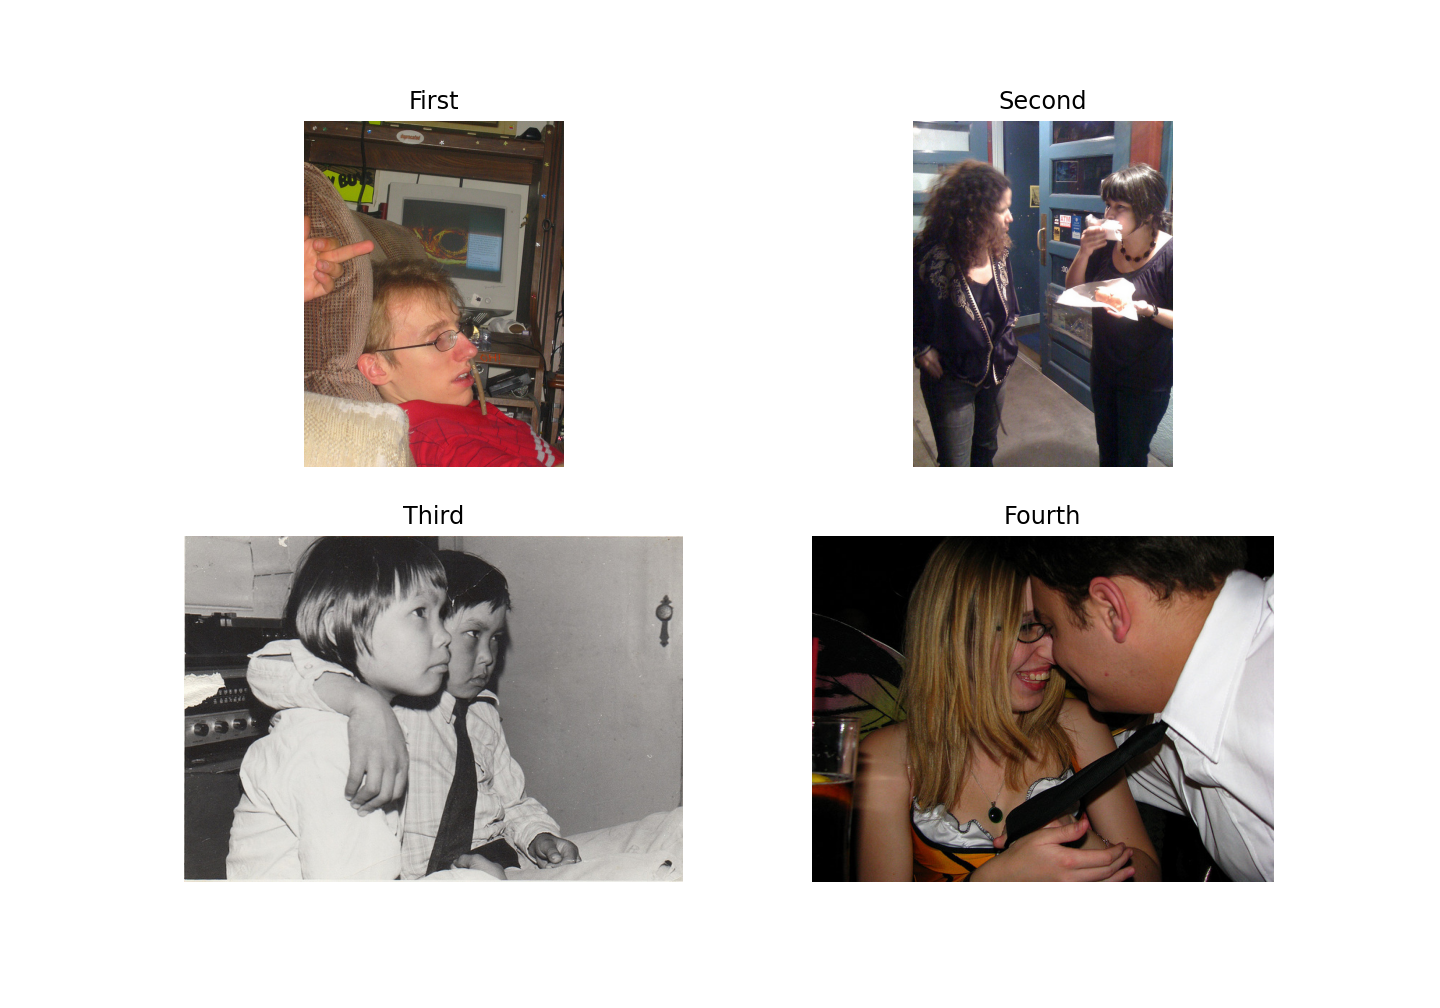

(200,) (82612, 200) (82612,)


Text(0.5, 1.0, 'Fourth')

In [413]:
from matplotlib import pyplot as plt
  
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 2
  
caption_vector = get_word_vectors(counter, "your mother")
images = query(caption_vector)
# reading images
Image1 = imgID2URL[images[0]]
Image2 = imgID2URL[images[1]]
Image3 = imgID2URL[images[2]]
Image4 = imgID2URL[images[3]]

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(download_image(Image1))
plt.axis('off')
plt.title("First")
  

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(download_image(Image2))
plt.axis('off')
plt.title("Second")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(download_image(Image3))
plt.axis('off')
plt.title("Third")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(download_image(Image4))
plt.axis('off')
plt.title("Fourth")


In [409]:
images

array([200446,  60370, 213532, 342696])

In [410]:
Image1

'http://images.cocodataset.org/train2014/COCO_train2014_000000200446.jpg'

In [411]:
Image2

'http://images.cocodataset.org/train2014/COCO_train2014_000000060370.jpg'